## 导入包

In [ ]:
import pandas as pd

import statsmodels.api as sm
import pandas as pd
import datetime
from pathlib import Path

pd.set_option("display.max_columns", None)
# !pip install statsmodels


# %config InlineBackend.figure_format = "svg"
# %config InlineBackend.print_figure_kwargs = {"dpi" : 300}
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd


# from cadFace.vis import percentiles_plot
import sci_palettes

try:
    sci_palettes.register_cmap()
except:
    pass
import scienceplots
from pathlib import Path
import pandas as pd
from ppp_aging.ppp_model import *
from ppp_aging.model import generate_states_cols

plt.style.use(["nature", "no-latex"])
sns.set_context("paper", font_scale=1.5)
sns.set_palette("nejm")

## 基础变量配置

In [ ]:
ukbData = "/home/xutingfeng/ukb/ukbData/"

olinkPath = ukbData + "omics/proteomics/Olink_v1.pkl"
all_pheno_path = ukbData + "phenotypes/tf/all_pheno.pkl"

protein_missing_drop_rate_cutoff = 0.2  # drop protein with missing rate > 0.2

## 读取数据

In [ ]:
olink = pd.read_pickle(olinkPath)
all_pheno = pd.read_pickle(all_pheno_path)

### olink 质控

In [ ]:
olink_missing_protein_rate = (olink.isna().sum(axis=0) / olink.shape[0]).sort_values(
    ascending=False
)

print(f"Missing protein rate top five protein: \n{olink_missing_protein_rate.head(5)}")
sns.histplot(olink_missing_protein_rate, bins=50)
# olink_missing_protein_rate
print(
    f"Protein missing rate > {protein_missing_drop_rate_cutoff} : {sum(olink_missing_protein_rate > protein_missing_drop_rate_cutoff)}"
)
print(
    f"droped proteins are: \n{' '.join(olink_missing_protein_rate[olink_missing_protein_rate > protein_missing_drop_rate_cutoff].index.tolist())}"
)
olink = olink.loc[
    :,
    olink_missing_protein_rate[
        olink_missing_protein_rate <= protein_missing_drop_rate_cutoff
    ].index,
]
print(
    f"Finnaly used protein number: {olink.shape[1]} with sample size: {olink.shape[0]}"
)

## final used protein imputed with mean

from ppp_aging.base import impute

olink_imputed = impute(olink.reset_index(drop=False), method="mean").set_index("eid")
olink_imputed

In [ ]:
# for col in protein_cols:
#     olink[col] = olink[col].astype(float)

olink_imputed.info()

## 数据合并

In [ ]:
pheno_cols = [
    "sex",
    "age",
    "dbp_a",
    "sbp_a",
    "ldl_a",
    "hdl_a",
    "tg_a",
    "tc_a",
    "apob",
]
cofounders = ["assessment_center", *[f"PC{i}" for i in range(1, 11)]]


# combinations

age_sex = ["age", "sex"]
risk_factors = [
    "age",
    "sex",
    "ldl_a",
    "hdl_a",
    "tc_a",
    "tg_a",
    "apob",
    "sbp_a",
    "dbp_a",
]


protein_cols = olink.columns.tolist()

## 定义incident CAD时间

In [ ]:
def define_time(data, Target="10Y-CAD incidence rate"):
    if Target == "10Y-CAD incidence rate":
        # data = data[data['incident_cad'] == 1]
        df = data[data["incident_cad"] != -1]

        def survival_time(x):
            cad_date = x["cad_date"]
            death_date = x["death_date"]
            recuit_date = x["recuit_date"]
            if pd.isnull(cad_date) and pd.isnull(death_date):
                return datetime.datetime.now() - recuit_date
            elif pd.isnull(cad_date) and pd.notnull(death_date):
                return death_date - recuit_date
            elif pd.notnull(cad_date) and pd.isnull(death_date):
                return datetime.datetime.now() - cad_date
            else:  # cad and death
                # raise ValueError(f"error, should not happen with {x}")
                return cad_date - recuit_date

        df.loc[:, "future_cad_time_days"] = df.apply(survival_time, axis=1)
        df["future_cad_time_months"] = np.ceil(df["future_cad_time_days"].dt.days / 30)
        df["future_cad_time_years"] = np.ceil(df["future_cad_time_days"].dt.days / 365)
        # df = df.reset_index(drop=True)

        E = "incident_cad"
        T = "future_cad_time_months"
        print(f"{E} have NA: {df[E].isna().sum()}, drop them")
        df = df.dropna(subset=[E])
        print(f"{T} have NA: {df[T].isna().sum()}, drop them")
        df = df.dropna(subset=[T])

        print(f"{E} and {T} dtype is {df[E].dtype} and {df[T].dtype}")
        if df[E].dtype != float:
            df[E] = df[E].astype(float)
        if df[T].dtype != float:
            df[T] = df[T].astype(float)

        print(f"Finnal used sample size: {df.shape[0]}")
        print(f"{E} value counts is : {df[E].value_counts()}")

        return df, E, T

In [ ]:
all_pheno, E, T = define_time(all_pheno)
all_pheno

In [ ]:
data_imputed = all_pheno.merge(
    olink_imputed, left_index=True, right_index=True
)  # imputed version
data = all_pheno.merge(olink, left_index=True, right_index=True)  # not imputed
del olink_imputed
del olink
del all_pheno
# data_imputed
print(
    f"Merged all pheno with olink data, shape: {data.shape}, imputed version, shape is {data_imputed.shape}"
)
print(f"{E} valuec counts is {data[E].value_counts()}")

## age bin划分


后续可能划分的更细一些

In [ ]:
data["age_bin"] = pd.cut(
    data["age"],
    bins=[0, 45, 50, 55, 60, 65, 70],
    labels=["0-45", "45-50", "50-55", "55-60", "60-65", "65-70"],
)

In [ ]:
# show age bin dist
data.groupby(["age_bin"]).value_counts(["incident_cad"])

In [ ]:
E, T

In [ ]:
age_bin_logit_subset_res = []

# res_dict = {}
from ppp_aging.model import cal_corr, generate_states_cols

for age_bin, age_bin_df in data.groupby("age_bin"):
    print(f"age bin: {age_bin}")
    single_association_proteins_result_df = cal_corr(
        age_bin_df, protein_cols, y=E, cofounders=risk_factors, model_type="logit"
    )  # 使用原始没有imputated版本

    single_association_proteins_result_df = generate_states_cols(
        single_association_proteins_result_df, "pvalue"
    )
    single_association_proteins_result_df["age_bin"] = age_bin
    single_association_proteins_result_df.sort_values(
        "LOG10P", ascending=False
    ).reset_index(drop=True).reset_index(drop=False, names="rank")

    age_bin_logit_subset_res.append(single_association_proteins_result_df)
age_bin_logit_subset_res_df = pd.concat(age_bin_logit_subset_res).reset_index(drop=True)
age_bin_logit_subset_res_df.to_csv("1.2_age_bin_logit_subset_res_df.csv", index=False)

In [15]:
# n_case = data.query(f"age_bin == '{age_bin}' & '{E}' == 1 ").shape[0]
# n_control = data.query(f"age_bin == '{age_bin}' & '{E}' == 0 ").shape[0]
age_bin_logit_subset_res_df

,var,exposure,model,pvalue,coef,std,z,upper,lower,AUC,ACC,Macro_F1,Sensitivity,Specificity,APR,pearsonr,spearmanr,explained_variance_score,r2_score,n_case,n_control,LOG10P,q_values,reject,markers,age_bin
0,C3,incident_cad,logit,0.692381,-0.118625,0.299843,-0.395625,-0.706306,0.469056,0.760579,0.632994,0.415175,0.819672,0.630552,0.057037,0.139886,0.106552,0.019148,0.019148,61.0,4255.0,0.159655,0.911547,False,,0-45
1,KLK7,incident_cad,logit,0.055031,-0.656959,0.342411,-1.918629,-1.328071,0.014154,0.778075,0.643564,0.419285,0.830508,0.641223,0.054406,0.144049,0.11151,0.020253,0.020253,59.0,4284.0,1.259390,0.322326,False,,0-45
2,GCHFR,incident_cad,logit,0.009397,0.428698,0.165057,2.597274,0.105192,0.752203,0.787912,0.677382,0.434531,0.816667,0.675669,0.056706,0.140848,0.116257,0.018698,0.018698,60.0,4295.0,2.027025,0.111648,False,,0-45
3,NHLRC3,incident_cad,logit,0.010867,1.098606,0.431345,2.546931,0.253185,1.944026,0.775465,0.708544,0.444774,0.741379,0.708333,0.063692,0.155604,0.109399,0.023786,0.023786,58.0,4296.0,1.963871,0.121208,False,,0-45
4,APOD,incident_cad,logit,0.149775,-0.635115,0.440952,-1.440328,-1.499364,0.229135,0.757426,0.670276,0.42905,0.75,0.669393,0.059943,0.148347,0.104124,0.021811,0.021811,60.0,4280.0,0.824561,0.533,False,,0-45
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17461,VWF,incident_cad,logit,0.000789,0.169505,0.050497,3.356765,0.070534,0.268477,0.678024,0.665078,0.525274,0.596413,0.673123,0.202202,0.20816,0.187349,0.043244,0.043244,669.0,5834.0,3.103142,0.011478,True,,65-70
17462,NOTCH3,incident_cad,logit,0.857202,0.019776,0.109904,0.179937,-0.195632,0.235184,0.673869,0.70875,0.545811,0.535127,0.728831,0.198623,0.202151,0.182977,0.040788,0.040788,669.0,5834.0,0.066917,0.9735,False,,65-70
17463,CNTN1,incident_cad,logit,0.014017,-0.315366,0.128363,-2.456829,-0.566954,-0.063779,0.67584,0.674304,0.529807,0.584454,0.684779,0.199363,0.204244,0.18505,0.041648,0.041648,669.0,5834.0,1.853347,0.105362,False,,65-70
17464,ENG,incident_cad,logit,0.40427,0.177044,0.212278,0.834019,-0.239014,0.593102,0.674355,0.704598,0.543902,0.541106,0.723517,0.197518,0.201917,0.183488,0.040704,0.040704,669.0,5834.0,0.393328,0.765172,False,,65-70


/home/xutingfeng/miniforge3/envs/rapids-24.02/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/xutingfeng/miniforge3/envs/rapids-24.02/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/xutingfeng/miniforge3/envs/rapids-24.02/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/xutingfeng/miniforge3/envs/rapids-24.02/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/xutingfeng/miniforge3/envs/rapids-24.02/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in log10
  result

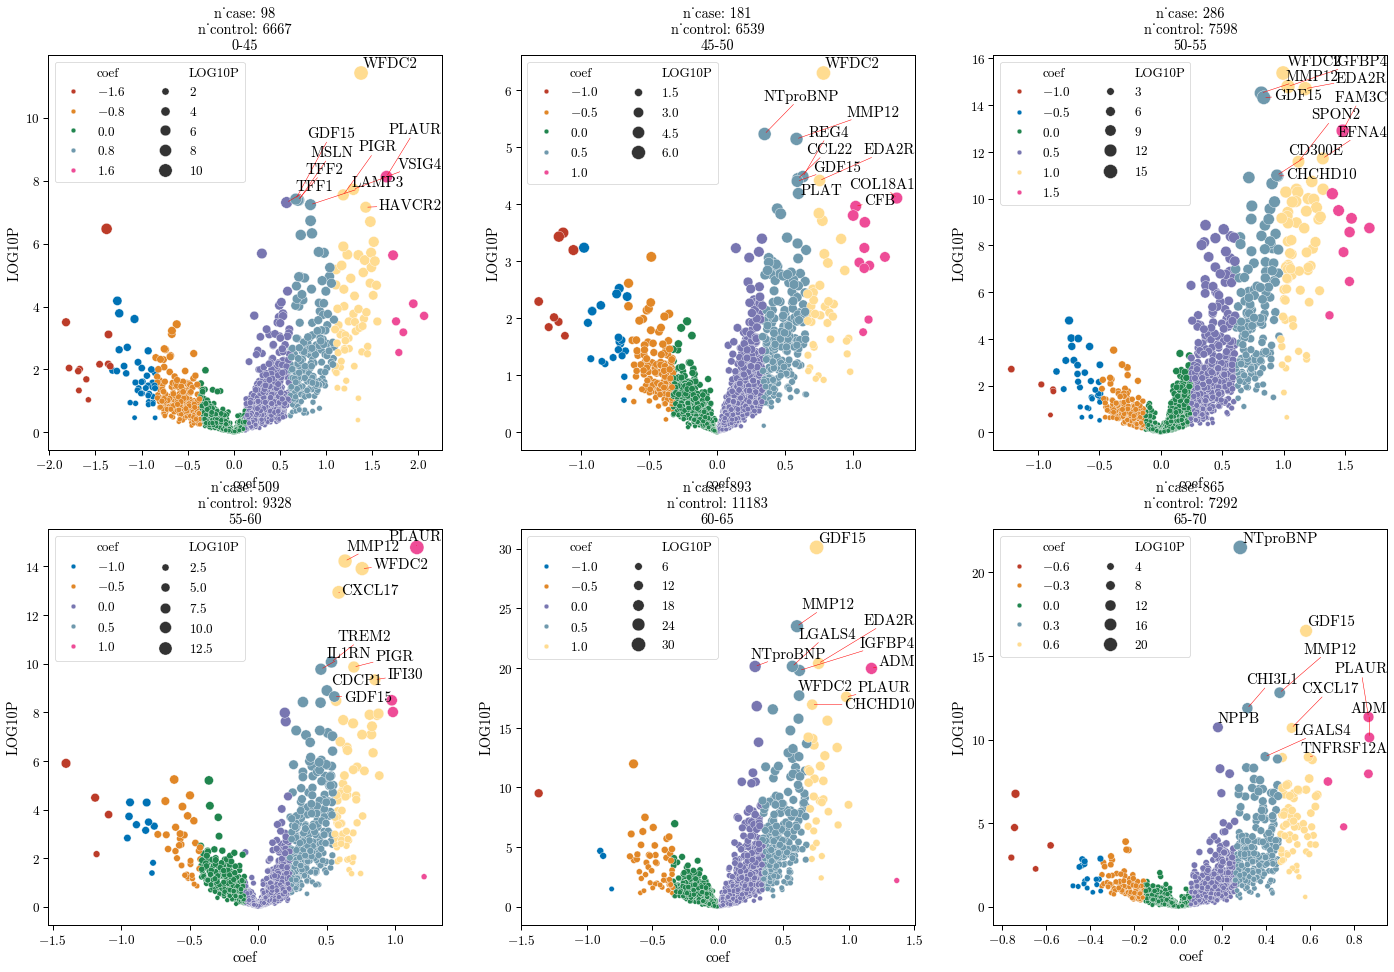

In [17]:
from ppp_aging.plot import volcano_plot


fig, axes = plt.subplots(2, 3, figsize=(24, 16))
axes = axes.flatten()
# for i, (age_bin, res) in enumerate(age_bin_subset_res.items()):
for i, (age_bin, age_df) in enumerate(age_bin_logit_subset_res_df.groupby("age_bin")):
    ax = axes[i]
    volcano_plot(
        age_df,
        x="coef",
        y="pvalue",
        hue="coef",
        k=10,
        name_col="var",
        ax=ax,
    )

    # TODO: add n_case while cal_corr
    bin_df = data.query(f"age_bin == '{age_bin}'")
    n_case = bin_df[bin_df[E] == 1].shape[0]
    n_control = bin_df[bin_df[E] == 0].shape[0]

    ax.set_title(f"n_case: {n_case}\nn_control: {n_control}\n{age_bin}")
    ax.legend(
        loc="upper left",
        bbox_to_anchor=(0, 1),
        ncol=2,
    )
# fig.tight_layout()

,var,exposure,model,pvalue,coef,std,z,upper,lower,AUC,ACC,Macro_F1,Sensitivity,Specificity,APR,pearsonr,spearmanr,explained_variance_score,r2_score,n_case,n_control,LOG10P,q_values,reject,markers,age_bin
0,C3,incident_cad,logit,0.692381,-0.118625,0.299843,-0.395625,-0.706306,0.469056,0.760579,0.632994,0.415175,0.819672,0.630552,0.057037,0.139886,0.106552,0.019148,0.019148,61.0,4255.0,0.159655,0.911547,False,,0-45
1,KLK7,incident_cad,logit,0.055031,-0.656959,0.342411,-1.918629,-1.328071,0.014154,0.778075,0.643564,0.419285,0.830508,0.641223,0.054406,0.144049,0.11151,0.020253,0.020253,59.0,4284.0,1.259390,0.322326,False,,0-45
2,GCHFR,incident_cad,logit,0.009397,0.428698,0.165057,2.597274,0.105192,0.752203,0.787912,0.677382,0.434531,0.816667,0.675669,0.056706,0.140848,0.116257,0.018698,0.018698,60.0,4295.0,2.027025,0.111648,False,,0-45
3,NHLRC3,incident_cad,logit,0.010867,1.098606,0.431345,2.546931,0.253185,1.944026,0.775465,0.708544,0.444774,0.741379,0.708333,0.063692,0.155604,0.109399,0.023786,0.023786,58.0,4296.0,1.963871,0.121208,False,,0-45
4,APOD,incident_cad,logit,0.149775,-0.635115,0.440952,-1.440328,-1.499364,0.229135,0.757426,0.670276,0.42905,0.75,0.669393,0.059943,0.148347,0.104124,0.021811,0.021811,60.0,4280.0,0.824561,0.533,False,,0-45
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17461,VWF,incident_cad,logit,0.000789,0.169505,0.050497,3.356765,0.070534,0.268477,0.678024,0.665078,0.525274,0.596413,0.673123,0.202202,0.20816,0.187349,0.043244,0.043244,669.0,5834.0,3.103142,0.011478,True,,65-70
17462,NOTCH3,incident_cad,logit,0.857202,0.019776,0.109904,0.179937,-0.195632,0.235184,0.673869,0.70875,0.545811,0.535127,0.728831,0.198623,0.202151,0.182977,0.040788,0.040788,669.0,5834.0,0.066917,0.9735,False,,65-70
17463,CNTN1,incident_cad,logit,0.014017,-0.315366,0.128363,-2.456829,-0.566954,-0.063779,0.67584,0.674304,0.529807,0.584454,0.684779,0.199363,0.204244,0.18505,0.041648,0.041648,669.0,5834.0,1.853347,0.105362,False,,65-70
17464,ENG,incident_cad,logit,0.40427,0.177044,0.212278,0.834019,-0.239014,0.593102,0.674355,0.704598,0.543902,0.541106,0.723517,0.197518,0.201917,0.183488,0.040704,0.040704,669.0,5834.0,0.393328,0.765172,False,,65-70


## 分析阶段


### 全部蛋白分析

全部蛋白和CAD、 生存分析、关联分析的关系以及总的预测效果（先说总的）

> 这里用到的蛋白是Imputed version
> 数据集的切分随机切分7：3的Train test切分

#### ALL protein 预测incident CAD

##### 蛋白质组
1. age +sex 的基线效果
2. age +sex + other factors 
3. all proteins + age +sex
4. all proteins + age + sex + other factors 

In [ ]:
import pandas as pd

import statsmodels.api as sm
from typing import Union, overload, Tuple, List
from sklearn.metrics import (
    r2_score,
    explained_variance_score,
    roc_auc_score,
    accuracy_score,
)
from scipy.stats import pearsonr, spearmanr


def cal_corr_multivar(
    df,
    x: Union[str, List[str]],
    y: str,
    cofounders: Union[str, list] = None,
    model_type="glm",
    family=sm.families.Gaussian(),
    return_all=False,
) -> pd.DataFrame:

    if isinstance(cofounders, str):
        cofounders = [cofounders]
    elif cofounders is None:
        cofounders = []

    assert model_type in [
        "glm",
        "ols",
        "logit",
    ], "model should be one of ['glm', 'ols', 'logit']"
    print(f"passed data have {df.shape[0]} rows")
    used_df = df[x + [y] + cofounders].dropna()

    X = sm.add_constant(used_df[x + cofounders])
    Y = used_df[y]
    print(f"used data have {used_df.shape[0]} rows after dropna")
    print(f"using input variables : {x + cofounders} to predict {y}")
    if model_type == "glm":
        model = sm.GLM(Y, X, family=family).fit()
        y_pred = model.predict(X)
        additional_metrics = {}
    elif model_type == "ols":
        model = sm.OLS(Y, X).fit()
        y_pred = model.predict(X)
        additional_metrics = {}
    elif model_type == "logit":
        model = sm.Logit(Y, X).fit()
        y_pred = model.predict(X)
        additional_metrics = {
            "roc_auc_score": roc_auc_score(Y, y_pred),
            "accuracy_score": accuracy_score(Y, (y_pred > 0.5).astype(int)),
        }

    used_df[f"{y}_pred"] = y_pred
    used_df[f"{y}_pred_zscore"] = (y_pred - y_pred.mean()) / y_pred.std()

    result_df = (
        model.summary2()
        .tables[1]
        .rename(
            columns={
                "Coef.": "coef",
                "Std.Err.": "std",
                "z": "z",
                "P>|z|": "pvalue",
                "[0.025": "upper_ci",
                "0.975]": "lower_ci",
            }
        )
    )
    result_df.index.name = "covariate"
    y_true = Y

    # result_df
    metrics = {
        "pearsonr": pearsonr(y_true, y_pred)[0],
        "spearmanr": spearmanr(y_true, y_pred)[0],
        "explained_variance_score": explained_variance_score(y_true, y_pred),
        "r2_score": r2_score(y_true, y_pred),
    }
    metrics.update(additional_metrics)

    return model, result_df, metrics, used_df

In [ ]:
from sklearn.model_selection import train_test_split

train_imputed, test_imputed = train_test_split(
    data_imputed, test_size=0.2, random_state=42
)

print(f"train shape: {train_imputed.shape}, test shape: {test_imputed.shape}")
print(
    f"train {E} have {train_imputed[E].value_counts()}, test {E} have {test_imputed[E].value_counts()}"
)

In [ ]:
from cuml import LogisticRegression, Lasso, Ridge, ElasticNet
from cuml.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import roc_auc_score, make_scorer


def fit_best_model(train_df, test_df, X_var, y_var, method_list=None, cv=10, verbose=1):
    models_params = {
        "Logistic": {
            "model": LogisticRegression(
                solver="qn", random_state=42, class_weight="balanced"
            ),
            "param_grid": {
                "C": np.logspace(-4, 4, 10),  # C参数的范围，使用对数间隔
                "penalty": ["l1", "l2"],  # 正则化类型
            },
        },
        "Lasso": {
            "model": Lasso(),
            "param_grid": {
                "alpha": np.logspace(-4, 4, 10),
            },
        },
        "ElasticNet": {
            "model": ElasticNet(),
            "param_grid": {
                "alpha": np.logspace(-4, 4, 10),
                "l1_ratio": np.linspace(0, 1, 10),
            },
        },
        # "RandomForest": {
        #     "model": RandomForestClassifier(),
        #     "param_grid": {"n_estimators": range(10, 101, 10)},
        # },
    }
    if method_list is not None:
        models_params = {k: v for k, v in models_params.items() if k in method_list}

    train_df = train_df[[y_var] + X_var].copy().dropna()
    test_df = test_df[[y_var] + X_var].copy().dropna()
    train_df[y_var] = train_df[y_var].astype(int)
    test_df[y_var] = test_df[y_var].astype(int)

    train_df, val_df = train_test_split(train_df, test_size=0.1, random_state=42)

    X_train = train_df[X_var]
    y_train = train_df[y_var]
    X_val = val_df[X_var]
    y_val = val_df[y_var]

    X_test = test_df[X_var]
    y_test = test_df[y_var]
    print(
        f"train shape: {X_train.shape}, val shape is {X_val.shape}, test shape is {X_test.shape}"
    )
    best_models = []

    for model_name, mp in models_params.items():
        # if model_name == "RandomForest":
        #     best_model = RandomForestClassifier(verbose=verbose)
        #     best_model.fit(X_train.values, y_train.values)
        #     auc = roc_auc_score(y_val, best_model.predict(X_val.values))
        #     bset_params = None  # no params for RandomForest

        # else:
        if model_name == "Logistic":
            scorer = make_scorer(roc_auc_score, needs_proba=True)
        else:
            scorer = make_scorer(roc_auc_score)

        grid_search = GridSearchCV(
            mp["model"], mp["param_grid"], scoring=scorer, cv=cv, verbose=verbose
        )
        grid_search.fit(X_train.values, y_train.values)

        best_model = grid_search.best_estimator_
        bset_params = grid_search.best_params_

        if model_name == "Logistic":
            auc = roc_auc_score(y_val, best_model.predict_proba(X_val.values)[:, 1])
        else:
            auc = roc_auc_score(y_val, best_model.predict(X_val.values))
        print(f"model: {model_name}\tBest parameters: {bset_params}, with auc: {auc}")
        best_models.append((model_name, best_model, grid_search, auc))

    ## select the currently best
    # print(best_models)

    # 还原原始的train_df
    train_df = pd.concat([train_df, val_df], axis=0)
    X_train = train_df[X_var]
    y_train = train_df[y_var]

    best_mdoels = list(sorted(best_models, key=lambda x: x[2], reverse=True))
    best_model_name, best_model, *_ = best_mdoels[0]

    if best_model_name == "Logistic":
        train_pred = best_model.predict_proba(X_train.values)[:, 1]

        test_pred = best_model.predict_proba(X_test.values)[:, 1]
    else:
        train_pred = best_model.predict(X_train.values)
        val_pred = best_model.predict(X_val.values)
        test_pred = best_model.predict(X_test.values)

    train_df[f"{y_var}_pred"] = train_pred

    test_df[f"{y_var}_pred"] = test_pred

    train_auc = roc_auc_score(y_train, train_pred)
    test_auc = roc_auc_score(y_test, test_pred)

    train_metrics = {
        "train_auc": train_auc,
    }
    test_metrics = {
        "test_auc": test_auc,
    }
    return best_model, train_metrics, test_metrics, train_df, test_df, best_mdoels

In [ ]:
from collections import defaultdict

Regression_model_result_dict = defaultdict(dict)

X_combination_dict = {
    "all_protein": protein_cols,
    "all_protein_age_sex": protein_cols + age_sex,
    "all_protein_risk_factors": protein_cols + risk_factors,
    "age_sex": age_sex,
    "risk_factors": risk_factors,
}

In [ ]:
# %%time
# methods = ["Lasso"]
# cv = 2
# for k, combination in X_combination_dict.items():
#     (
#         model,
#         train_metrics,
#         test_metrics,
#         train_imputed_data,
#         test_imputed_data,
#         best_models,
#     ) = fit_best_model(
#         train_df=train_imputed,
#         test_df=test_imputed,
#         X_var=X_combination_dict[k],
#         y_var=E,
#         method_list=methods,
#         cv=cv,
#     )
#     print(
#         f"{k} train auc: {train_metrics['train_auc']}, test auc: {test_metrics['test_auc']}"
#     )
#     Regression_model_result_dict[k] = {
#         "model": model,
#         "train_metrics": train_metrics,
#         "test_metrics": test_metrics,
#         "train_data": train_imputed_data,
#         "test_data": test_imputed_data,
#         "best_models": best_models,
#     }

In [ ]:
# from ppp_aging.model import generate_states_cols

# for k, combination in X_combination_dict.items():
#     model, result_df, train_metrics, train_df = cal_corr_multivar(
#         train_imputed, combination, E, cofounders=None, model_type="logit"
#     )

#     result_df = generate_states_cols(result_df, "pvalue")

#     test_df = test_imputed[combination + [E]].dropna()
#     test_df[f"{E}_pred"] = model.predict(sm.add_constant(test_df[combination]))
#     # no zscore cal here ; may added later
#     test_metrics = {"roc_auc_score": roc_auc_score(test_df[E], test_df[f"{E}_pred"])}

#     Regression_model_result_dict[k] = {
#         "model": model,
#         "result_df": result_df,
#         "train_metrics": train_metrics,
#         "train_df": train_df,
#         "test_metrics": test_metrics,
#         "test_df": test_df,
#     }
#     print(f"{k} for {E} is :{train_metrics}")
#     print(f"{k} for {E} test is :{test_metrics}")
#     break

##### 与PRS进行对比

In [ ]:
PRS_path = "/home/xutingfeng/ukb/ukbData/PRS/ldpred2_cxy.tsv"
PRS = pd.read_csv(PRS_path, sep="\t")
PRS.columns = ["eid", "PRS"]
PRS = PRS.set_index("eid")
PRS.index = PRS.index.astype(data_imputed.index.dtype)
PRS["PRS"] = -1 * PRS["PRS"]

PRS_train = PRS.merge(
    train_imputed[[E, T] + risk_factors + cofounders], left_index=True, right_index=True
)
PRS_test = PRS.merge(
    test_imputed[[E, T] + risk_factors + cofounders], left_index=True, right_index=True
)
print(f"PRS train shape: {PRS_train.shape}, PRS test shape: {PRS_test.shape}")

In [ ]:
X_PRS_combination_dict = {
    "PRS_age_sex": ["PRS"] + age_sex,
    "PRS_risk_factors": ["PRS"] + risk_factors,
}
X_combination_dict.update(X_PRS_combination_dict)
X_combination_dict.keys()
# PC1 -PC10 gene_array assesment center

In [ ]:
# # %%time
# methods = ["Lasso"]
# cv = 2
# for k, combination in X_PRS_combination_dict.items():
#     (
#         model,
#         train_metrics,
#         test_metrics,
#         train_imputed_data,
#         test_imputed_data,
#         best_models,
#     ) = fit_best_model(
#         train_df=PRS_train,
#         test_df=PRS_test,
#         X_var=X_PRS_combination_dict[k],
#         y_var=E,
#         method_list=methods,
#         cv=cv,
#     )
#     print(
#         f"{k} train auc: {train_metrics['train_auc']}, test auc: {test_metrics['test_auc']}"
#     )
#     Regression_model_result_dict[k] = {
#         "model": model,
#         "train_metrics": train_metrics,
#         "test_metrics": test_metrics,
#         "train_data": train_imputed_data,
#         "test_data": test_imputed_data,
#         "best_models": best_models,
#     }

In [ ]:
# PRS_metrics_binary = {"roc_auc_score": roc_auc_score()}
for k, combination in X_PRS_combination_dict.items():

    model, result_df, train_metrics, train_df = cal_corr_multivar(
        PRS_train, combination, E, cofounders=cofounders, model_type="logit"
    )

    result_df = generate_states_cols(result_df, "pvalue")

    test_df = PRS_test[combination + [E] + cofounders].dropna()
    test_df[f"{E}_pred"] = model.predict(
        sm.add_constant(test_df[combination + cofounders])
    )

    # no zscore cal here ; may added later
    test_metrics = {"roc_auc_score": roc_auc_score(test_df[E], test_df[f"{E}_pred"])}

    Regression_model_result_dict["PRS"] = {
        "model": model,
        "result_df": result_df,
        "train_metrics": train_metrics,
        "train_df": train_df,
        "test_metrics": test_metrics,
        "test_df": test_df,
    }

    print(f"{k} for {E} is :{train_metrics}")
    print(f"{k} for {E} test is :{test_metrics}")

    # print(roc_auc_score(PRS_train[E], PRS_train["PRS"]))

In [ ]:
# fig, ax = plt.subplots(1, 1, figsize=(12, 6))
# test_all_metrics = [
#     [k, v["test_metrics"]["test_auc"]] for k, v in Regression_model_result_dict.items()
# ]
# # train_all_metrics = [
# #     [k, v["train_metrics"]] for k, v in Regression_model_result_dict.items()
# # ]
# test_all_metrics_df = pd.DataFrame(test_all_metrics, columns=["model", "test_auc"])
# # train_all_metrics_df = pd.DataFrame(train_all_metrics, columns=["model", "train_auc"])

# plt_data = test_all_metrics_df.sort_values("test_auc", ascending=False)
# sns.barplot(
#     data=plt_data,
#     x="model",
#     y="test_auc",
#     ax=ax,
#     gap=0.5,
#     palette="viridis",
# )
# ax.set_ylim(0.7, 0.78)

# for tick in ax.get_xticklabels():
#     tick.set_rotation(45)
#     tick.set_fontsize(12)

# for patch in ax.patches:
#     ax.text(
#         patch.get_x() + patch.get_width() / 2,
#         patch.get_height(),
#         f"{patch.get_height():.3f}",
#         ha="center",
#         fontsize=12,
#     )

##### 计算OR（这是最后部分做的事情）

In [ ]:
## 提取分数
score_list = []
for k, v in Regression_model_result_dict.items():
    # out = pd.concat(
    #     [v["train_data"][[f"{E}_pred"]], v["test_data"][[f"{E}_pred"]]]
    # )

    tmp_train_df = v["train_data"][[f"{E}_pred"]]
    tmp_test_df = v["test_data"][[f"{E}_pred"]]

    tmp_train_mean, tmp_train_std = (
        tmp_train_df[f"{E}_pred"].mean(),
        tmp_train_df[f"{E}_pred"].std(),
    )

    tmp_test_df[f"{k}_{E}_pred_zscore"] = tmp_test_df[f"{E}_pred"].apply(
        lambda x: (x - tmp_train_mean) / tmp_train_std
    )

    score_list.append(tmp_test_df[[f"{k}_{E}_pred_zscore"]])
from functools import reduce

score_df = reduce(
    lambda x, y: pd.merge(x, y, left_index=True, right_index=True), score_list
)

In [ ]:
score_cols = score_df.columns.tolist()


score_data = data[
    [E, T] + risk_factors + [i for i in cofounders if i not in risk_factors]
].merge(score_df, left_index=True, right_index=True)
score_data

In [ ]:
score_data

<!-- #### All protein 预测 未来CAD的生存分析 -->

In [ ]:
from lifelines import CoxPHFitter

In [ ]:
cph = CoxPHFitter()
single_var_res = []
for var in score_cols:
    tmp_df = score_data[[var, E, T] + cofounders].dropna()
    cph.fit(tmp_df, duration_col=T, event_col=E)
    summary_df = cph.summary
    summary_df["N"] = tmp_df.shape[0]
    single_var_res.append(summary_df.loc[[var]])
    print(
        f"pvalue of {var}: {cph.summary['p'][var]}, < 0.05 {cph.summary['p'][var] < 0.05}"
    )

In [ ]:
from ppp_aging.model import generate_states_cols

single_var_res_df = pd.concat(single_var_res)
single_var_res_df = generate_states_cols(single_var_res_df, pvalue_col="p")
single_var_res_df["formatted_qval"] = single_var_res_df["p"].apply(lambda x: f"{x:.2e}")

single_var_res_df

In [ ]:
import forestplot as fp

fig, ax = plt.subplots(figsize=(6, 4))
fp.forestplot(
    single_var_res_df.reset_index(),
    estimate="exp(coef)",
    ll="exp(coef) lower 95%",
    hl="exp(coef) upper 95%",
    varlabel="covariate",
    ylabel="",
    xlabel="exp(coef)",
    capitalize=True,
    rightannote=["formatted_qval"],
    right_annoteheaders=["q_values"],
    table=True,
    sort=True,
    sortby="q_values",
    color_alt_rows=True,
    ax=ax,
    mcolor=["#CC6677", "#4477AA"],
    # Additional kwargs for customizations
    **{
        "markersize": 30,
        # override default vertical offset between models (0.0 to 1.0)
        "offset": 0.35,
        "xlinestyle": (0, (10, 5)),  # long dash for x-reference line
        "xlinecolor": ".8",  # gray color for x-reference line
    },
)
fig.tight_layout()
# fig.savefig("aging_result/bootstrap_model_corrs/forestplot_age_gap_vs_cadAndDeath.png",  dpi="figure", bbox_inches="tight")

### 全部蛋白太多了，且相关性很大

#### 根据模型参数选择蛋白子集

这个策略不好解释，并且不好去说选多少，选那些

In [ ]:
coef = Regression_model_result_dict["all_protein"]["model"].coef_
params = X_combination_dict["all_protein"]

all_protein_lasso_base_coef = pd.DataFrame({"params": params, "coef": coef}).set_index(
    "params"
)

sns.kdeplot(all_protein_lasso_base_coef["coef"])

In [ ]:
subset_test = (
    np.abs(all_protein_lasso_base_coef["coef"])
    .sort_values(ascending=False)
    .head(200)
    .index.tolist()
)
fit_best_model(
    train_imputed,
    test_imputed,
    subset_test + risk_factors,
    E,
    method_list=["Lasso"],
    cv=2,
)

#### 根据单因素分析进行选择

选择与risk_factors没有较多共线性的蛋白出来




In [ ]:
sig_subset_dict = {}

##### 单因素关联分析

In [ ]:
# res_dict = {}
from ppp_aging.model import cal_corr

single_association_proteins_result_df = cal_corr(
    data, protein_cols, y=E, cofounders=risk_factors, model_type="logit"
)  # 使用原始没有imputated版本

In [ ]:
# import pandas as pd
# from sklearn.metrics import (
#     r2_score,
#     explained_variance_score,
#     roc_auc_score,
#     accuracy_score,
# )
# from scipy.stats import pearsonr, spearmanr
# import statsmodels.api as sm
# from typing import Union, overload, Tuple, List
# from tqdm import tqdm


# def split_list_into_k_chunks(lst, k):
#     """
#     将列表lst分成k个尽可能平均的子列表

#     参数:
#     lst: 要分割的原始列表
#     k: 目标子列表的数量

#     返回:
#     一个列表，包含k个子列表（chunks）
#     """
#     # 计算每个chunk的平均长度，使用整除得到基本长度
#     chunk_size = len(lst) // k
#     # 计算需要额外分配一个元素的chunk数量
#     chunks_with_extra = len(lst) % k

#     chunks = []
#     start_index = 0
#     for i in range(k):
#         # 如果当前chunk在前chunks_with_extra个chunk中，则长度为chunk_size+1
#         # 否则长度为chunk_size
#         end_index = start_index + chunk_size + (1 if i < chunks_with_extra else 0)
#         # 从原始列表中切片，创建新的chunk
#         chunk = lst[start_index:end_index]
#         chunks.append(chunk)
#         # 更新下一个chunk的起始索引
#         start_index = end_index

#     return chunks


# def parallel_cal_corr(df_x_tuple, y, cofounders, model_type, family):
#     df, x = df_x_tuple
#     return cal_corr(df, x, y, cofounders, model_type, family, return_all=False)


# @overload
# def cal_corr(
#     df,
#     x: List[str],
#     y: str,
#     cofounders: Union[str, list] = None,
#     model_type="glm",
#     family=sm.families.Gaussian(),
# ) -> pd.DataFrame: ...
# @overload
# def cal_corr(
#     df,
#     x: str,
#     y: str,
#     cofounders: Union[str, list] = None,
#     model_type="glm",
#     family=sm.families.Gaussian(),
# ) -> pd.DataFrame: ...
# @overload
# def cal_corr(
#     df,
#     x: str,
#     y: str,
#     cofounders: Union[str, list] = None,
#     model_type="ols",
#     family=sm.families.Gaussian(),
#     return_all=True,
# ) -> Tuple[sm.GLM, pd.DataFrame, pd.DataFrame]: ...
# def cal_corr(
#     df,
#     x: Union[str, List[str]],
#     y: str,
#     cofounders: Union[str, list] = None,
#     model_type="glm",
#     family=sm.families.Gaussian(),
#     return_all=False,
#     parallel_cores=None,
# ) -> pd.DataFrame:
#     if isinstance(x, list):
#         if parallel_cores is not None and return_all == False:
#             from multiprocessing import Pool
#             from functools import partial

#             x_split = split_list_into_k_chunks(x, k=parallel_cores)
#             df_x_split = [(df[x_ + cofounders + [y]], x_) for x_ in x_split]

#             parallel_func = partial(
#                 parallel_cal_corr,
#                 y=y,
#                 cofounders=cofounders,
#                 model_type=model_type,
#                 family=family,
#             )

#             with Pool(parallel_cores) as p:
#                 res = list(
#                     tqdm(p.imap(parallel_func, df_x_split), total=len(df_x_split))
#                 )

#             return pd.concat(res)
#         result = []
#         for x_ in tqdm(x):
#             current_res = cal_corr(
#                 df, x_, y, cofounders, model_type, family, return_all=return_all
#             )
#             if current_res is not None:
#                 result.append(current_res)

#         if return_all:
#             model_list = [x[0] for x in result]
#             result_df = [x[1] for x in result]
#             pred_df = [x[2] for x in result]
#             return model_list, pd.concat(result_df, axis=1).T, pred_df
#         # return pd.concat(result, axis=1 ).T
#         else:
#             return pd.concat(result, axis=1).T
#         # return result

#     if isinstance(cofounders, str):
#         cofounders = [cofounders]
#     elif cofounders is None:
#         cofounders = []

#     assert model_type in [
#         "glm",
#         "ols",
#         "logit",
#     ], "model should be one of ['glm', 'ols', 'logit']"
#     print(f"passed data have {df.shape[0]} rows")
#     used_df = df[[x, y] + cofounders].dropna()

#     X = sm.add_constant(used_df[[x] + cofounders])
#     Y = used_df[y]
#     print(f"used data have {used_df.shape[0]} rows after dropna")
#     if model_type == "glm":
#         model = sm.GLM(Y, X, family=family).fit()
#         y_pred = model.predict(X)

#         metrics = {"Persudo_R2": model.pseudo_rsquared()}
#     elif model_type == "ols":
#         model = sm.OLS(Y, X).fit()
#         y_pred = model.predict(X)

#         metrics = {"Persudo_R2": model.pseudo_rsquared()}
#     elif model_type == "logit":
#         model = sm.Logit(Y, X).fit()
#         y_pred = model.predict(X)

#         metrics = {
#             "roc_auc_score": roc_auc_score(Y, y_pred),
#             "accuracy_score": accuracy_score(Y, (y_pred > 0.5).astype(int)),
#         }
#     y_true = used_df[y]
#     metrics.update(
#         {
#             "pearsonr": pearsonr(y_true, y_pred)[0],
#             "spearmanr": spearmanr(y_true, y_pred)[0],
#             "explained_variance_score": explained_variance_score(y_true, y_pred),
#             "r2_score": r2_score(y_true, y_pred),
#         }
#     )

#     model_res = (
#         model.summary2()
#         .tables[1]
#         .rename(
#             columns={
#                 "Coef.": "coef",
#                 "Std.Err.": "std",
#                 "z": "z",
#                 "P>|z|": "pvalue",
#                 "[0.025": "upper_ci",
#                 "0.975]": "lower_ci",
#             }
#         )
#         .loc[x]
#         .to_dict()
#     )

#     result = {
#         "var": x,
#         "exposure": y,
#         "model": model_type,
#         "pvalue": model.pvalues[x],
#         "coef": model.params[x],
#         "std": model_res["std"],
#         "z": model_res["z"],
#         "upper": model_res["upper_ci"],
#         "lower": model_res["lower_ci"],
#     }
#     result.update(metrics)

#     used_df[f"{y}_pred"] = y_pred

#     result = pd.Series(result)
#     if return_all:
#         return model, result, used_df
#     return result

In [ ]:
# %%time
# single_association_proteins_result_df = cal_corr(
#     data,
#     protein_cols,
#     y=E,
#     cofounders=risk_factors,
#     model_type="logit",
#     parallel_cores=2,
# )  # 使用原始没有imputated版本

In [ ]:
single_association_proteins_result_df = generate_states_cols(
    single_association_proteins_result_df, "pvalue"
)
single_association_proteins_result_df.head()

In [ ]:
from ppp_aging.plot import volcano_plot

fig, ax = plt.subplots(1, 1, figsize=(6, 8))

volcano_plot(
    single_association_proteins_result_df,
    x="coef",
    y="pvalue",
    hue="coef",
    k=10,
    name_col="var",
    ax=ax,
)
ax.set_title(E)

In [ ]:
single_association_proteins_result_df_sig = single_association_proteins_result_df[
    single_association_proteins_result_df["LOG10P"] > 10
]
single_association_proteins_result_df_sig.sort_values("LOG10P", ascending=False)

In [ ]:
sig_subset_dict["single_logit_sig"] = single_association_proteins_result_df_sig[
    "var"
].tolist()

In [ ]:
_, single_logit_sig_multivar_res, *_ = cal_corr_multivar(
    data_imputed, x=sig_subset_dict["single_logit_sig"], y=E, model_type="logit"
)
single_logit_sig_multivar_res = (
    generate_states_cols(single_logit_sig_multivar_res).reset_index(drop=False).iloc[1:]
)
single_logit_sig_multivar_res

In [ ]:
single_logit_sig_multivar_res.sort_values("LOG10P", ascending=False)

In [ ]:
single_logit_sig_multivar_res_sig = single_logit_sig_multivar_res[
    single_logit_sig_multivar_res["LOG10P"] > 2
]
single_logit_sig_multivar_res_sig

In [ ]:
import forestplot as fp

fig, ax = plt.subplots(figsize=(10, 10))
# plt_data = res_df[res_df['y'] == 'cad']
plt_data = single_logit_sig_multivar_res_sig
plt_data["formatted_qval"] = plt_data["q_values"].apply(lambda x: f"{x:.2e}")

fp.forestplot(
    plt_data.reset_index(),
    estimate="coef",
    ll="upper_ci",
    hl="lower_ci",
    varlabel="covariate",
    ylabel="",
    xlabel="coef",
    capitalize=True,
    rightannote=["formatted_qval"],
    right_annoteheaders=["q_values"],
    table=True,
    sort=True,
    color_alt_rows=True,
    ax=ax,
    mcolor=["#CC6677", "#4477AA"],
    # Additional kwargs for customizations
    **{
        "markersize": 30,
        # override default vertical offset between models (0.0 to 1.0)
        "offset": 0.35,
        "xlinestyle": (0, (10, 5)),  # long dash for x-reference line
        "xlinecolor": ".8",  # gray color for x-reference line
    },
)
fig.tight_layout()

In [ ]:
sig_subset_dict["single_logit_sig_multivar_res_sig"] = (
    single_logit_sig_multivar_res_sig["covariate"].tolist()
)

#### 单因素生存分析

In [ ]:
"""
多变量分析
"""

from lifelines import CoxPHFitter

single_survival_analysis = []

for var in protein_cols:

    cph = CoxPHFitter()
    # df传入DataFrame格式数据，duration_col传入时间的列名，event_col传入事件的列名，默认是使用全部协变量
    # 可以通过参数formula='Age+Race'，传入部分协变量

    cph.fit(
        data[[var, *risk_factors] + [E, T]].dropna(),
        duration_col=T,
        event_col=E,
        show_progress=True,
    )
    # cph.fit(df =df[['age', 'sex', E, T]].dropna(), duration_col=T, event_col=E, show_progress=True)
    # 打印模型情况
    # cph.print_summary()
    # fig, ax = plt.subplots(figsize=(10, 5))
    # cph.plot(ax=ax, hazard_ratios=True)
    single_survival_analysis.append(cph.summary.loc[[var]])

In [ ]:
single_survival_analysis_df = generate_states_cols(
    pd.concat(single_survival_analysis), "p"
).reset_index(drop=False)
single_survival_analysis_df

In [ ]:
from ppp_aging.plot import volcano_plot

fig, ax = plt.subplots(1, 1, figsize=(6, 8))

volcano_plot(
    single_survival_analysis_df,
    x="coef",
    y="p",
    hue="coef",
    k=10,
    name_col="covariate",
    ax=ax,
)
ax.set_title(E)

In [ ]:
single_survival_analysis_result_df_sig = single_survival_analysis_df[
    single_survival_analysis_df["LOG10P"] > 10
]
single_survival_analysis_result_df_sig.sort_values("LOG10P", ascending=False)

In [ ]:
sig_subset_dict["single_surivival_sig"] = single_survival_analysis_result_df_sig[
    "covariate"
].tolist()

In [ ]:
cph = CoxPHFitter()
# df传入DataFrame格式数据，duration_col传入时间的列名，event_col传入事件的列名，默认是使用全部协变量
# 可以通过参数formula='Age+Race'，传入部分协变量

cph.fit(
    data[
        sig_subset_dict["single_surivival_sig"]
        #   + risk_factors
        + [E, T]
    ].dropna(),
    duration_col=T,
    event_col=E,
    show_progress=True,
)
# cph.fit(df =df[['age', 'sex', E, T]].dropna(), duration_col=T, event_col=E, show_progress=True)
# 打印模型情况
# cph.print_summary()
# fig, ax = plt.subplots(figsize=(10, 5))
# cph.plot(ax=ax, hazard_ratios=True)

cph.plot(hazard_ratios=True)

In [ ]:
single_surivival_sig_multivar_res = generate_states_cols(
    cph.summary.sort_values("p", ascending=True).reset_index(drop=False), "p"
)
single_surivival_sig_multivar_res_sig = single_surivival_sig_multivar_res[
    single_surivival_sig_multivar_res["LOG10P"] > 2
]
single_surivival_sig_multivar_res_sig

In [ ]:
import forestplot as fp

fig, ax = plt.subplots(figsize=(8, 8))
# plt_data = res_df[res_df['y'] == 'cad']
plt_data = single_surivival_sig_multivar_res_sig
plt_data["formatted_qval"] = plt_data["q_values"].apply(lambda x: f"{x:.2e}")

fp.forestplot(
    plt_data,
    estimate="exp(coef)",
    ll="exp(coef) lower 95%",
    hl="exp(coef) upper 95%",
    varlabel="covariate",
    ylabel="",
    xlabel="exp(coef)",
    capitalize=True,
    rightannote=["formatted_qval"],
    right_annoteheaders=["q_values"],
    table=True,
    sort=True,
    color_alt_rows=True,
    ax=ax,
    mcolor=["#CC6677", "#4477AA"],
    # Additional kwargs for customizations
    **{
        "markersize": 30,
        # override default vertical offset between models (0.0 to 1.0)
        "offset": 0.35,
        "xlinestyle": (0, (10, 5)),  # long dash for x-reference line
        "xlinecolor": ".8",  # gray color for x-reference line
    },
)
fig.tight_layout()

In [ ]:
sig_subset_dict["single_surivival_sig_multivar_res_sig"] = (
    single_surivival_sig_multivar_res_sig["covariate"].tolist()
)

In [ ]:
# _, single_surivival_sig_multivar_res, *_ = cal_corr_multivar(
#     data_imputed, x=sig_subset_dict["single_surivival_sig"], y=E, model_type="logit"
# )
# single_surivival_sig_multivar_res = (
#     generate_states_cols(single_surivival_sig_multivar_res)
#     .reset_index(drop=False)
#     .iloc[1:]
# )
# single_surivival_sig_multivar_res.sort_values("LOG10P", ascending=False)

#### 这部分subset和PRS以及RiskFactor组合 在一块

In [ ]:
# 加入PRS
if "PRS" not in train_imputed.columns:
    train_imputed = train_imputed.merge(PRS_train)
    test_imputed = test_imputed.merge(PRS_test)

In [ ]:
# sig_subset_dict["single_surivival_sig_multivar_res_sig"]

for k in sig_subset_dict.copy().keys():
    v = sig_subset_dict[k]

    sig_subset_dict[f"{k}_risk_factors"] = v + risk_factors
    sig_subset_dict[f"{k}_risk_factors_PRS"] = v + ["PRS"] + risk_factors

In [ ]:
sig_subset_dict.keys()

In [ ]:
X_combination_dict.update(sig_subset_dict)

### single_logit_sig_multivar_res_sig 与single_surivival_sig_multivar_res_sig


In [ ]:
single_logit_sig_multivar_res_sig_dict = {}

multivar_merge_logit_surivival = list(
    set(
        sig_subset_dict["single_surivival_sig_multivar_res_sig"]
        + sig_subset_dict["single_logit_sig_multivar_res_sig"]
    )
)
print(f"multivar_merge_logit_surivival: {len(multivar_merge_logit_surivival)}")
single_logit_sig_multivar_res_sig_dict["multivar_merge_logit_surivival"] = (
    multivar_merge_logit_surivival
)
single_logit_sig_multivar_res_sig_dict[
    "multivar_merge_logit_surivival_risk_factors"
] = (multivar_merge_logit_surivival + risk_factors)
single_logit_sig_multivar_res_sig_dict[
    "multivar_merge_logit_surivival_risk_factors_PRS"
] = (multivar_merge_logit_surivival + ["PRS"] + risk_factors)

In [ ]:
X_combination_dict.update(single_logit_sig_multivar_res_sig_dict)

In [ ]:
print(f"Currently have combinations: {X_combination_dict.keys()}")

### 保存结果

In [ ]:
import json

json.dump(X_combination_dict, open("1_X_combination_dict.json", "w"))

In [ ]:
single_association_proteins_result_df.to_csv(
    "1_single_association_proteins_result_df.csv", index=False
)
single_survival_analysis_df.to_csv("1_single_survival_analysis_df", index=False)

In [ ]:
train_imputed.to_pickle("1_train_imputed.pkl")
test_imputed.to_pickle("1_test_imputed.pkl")

#### 比较这些显著subset

In [ ]:
# 加入PRS
if "PRS" not in train_imputed.columns:
    train_imputed = train_imputed.merge(PRS_train)
    test_imputed = test_imputed.merge(PRS_test)

In [ ]:
print(sig_subset_dict.keys())

In [ ]:
# sig_subset_dict["single_surivival_sig_multivar_res_sig"]

for k in sig_subset_dict.copy().keys():
    v = sig_subset_dict[k]

    sig_subset_dict[f"{k}_risk_factors"] = v + risk_factors
    sig_subset_dict[f"{k}_risk_factors_PRS"] = v + ["PRS"] + risk_factors

In [ ]:
sig_subset_dict["single_logit_sig_multivar_res_sig_risk_factors_PRS"]

In [ ]:
# # %%time
# methods = ["Lasso"]
# cv = 2
# for k, combination in sig_subset_dict.items():
#     print(f"start {k}")
#     (
#         model,
#         train_metrics,
#         test_metrics,
#         train_imputed_data,
#         test_imputed_data,
#         best_models,
#     ) = fit_best_model(
#         train_df=train_imputed,
#         test_df=test_imputed,
#         X_var=sig_subset_dict[k],
#         y_var=E,
#         method_list=methods,
#         cv=cv,
#     )
#     print(
#         f"{k} train auc: {train_metrics['train_auc']}, test auc: {test_metrics['test_auc']}"
#     )
#     Regression_model_result_dict[k] = {
#         "model": model,
#         "train_metrics": train_metrics,
#         "test_metrics": test_metrics,
#         "train_data": train_imputed_data,
#         "test_data": test_imputed_data,
#         "best_models": best_models,
#     }
#     print(f"end {k}")

In [ ]:
# # %%time
# methods = ["Lasso"]
# cv = 2
# for k, combination in sig_subset_dict.items():
#     if k in Regression_model_result_dict.keys():
#         print(f"{k} already in result dict")
#         continue
#     (
#         model,
#         train_metrics,
#         test_metrics,
#         train_imputed_data,
#         test_imputed_data,
#         best_models,
#     ) = fit_best_model(
#         train_df=train_imputed,
#         test_df=test_imputed,
#         X_var=sig_subset_dict[k],
#         y_var=E,
#         method_list=methods,
#         cv=cv,
#     )
#     print(
#         f"{k} train auc: {train_metrics['train_auc']}, test auc: {test_metrics['test_auc']}"
#     )
#     Regression_model_result_dict[k] = {
#         "model": model,
#         "train_metrics": train_metrics,
#         "test_metrics": test_metrics,
#         "train_data": train_imputed_data,
#         "test_data": test_imputed_data,
#         "best_models": best_models,
#     }

In [ ]:
# sig_subset_dict["single_surivival_sig_multivar_res_sig_risk_factors_PRS"]

In [ ]:
# %%time
methods = ["Lasso", "ElasticNet", "Logistic"]
cv = 10
for k, combination in sig_subset_dict.items():
    print(f"start {k}")
    (
        model,
        train_metrics,
        test_metrics,
        train_imputed_data,
        test_imputed_data,
        best_models,
    ) = fit_best_model(
        train_df=train_imputed,
        test_df=test_imputed,
        X_var=sig_subset_dict[k],
        y_var=E,
        method_list=methods,
        cv=cv,
    )
    print(
        f"{k} train auc: {train_metrics['train_auc']}, test auc: {test_metrics['test_auc']}"
    )
    Regression_model_result_dict[k] = {
        "model": model,
        "train_metrics": train_metrics,
        "test_metrics": test_metrics,
        "train_data": train_imputed_data,
        "test_data": test_imputed_data,
        "best_models": best_models,
    }
    print(f"end {k}")

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
test_all_metrics = [
    [k, v["test_metrics"]["test_auc"]] for k, v in Regression_model_result_dict.items()
]
# train_all_metrics = [
#     [k, v["train_metrics"]] for k, v in Regression_model_result_dict.items()
# ]
test_all_metrics_df = pd.DataFrame(test_all_metrics, columns=["model", "test_auc"])
# train_all_metrics_df = pd.DataFrame(train_all_metrics, columns=["model", "train_auc"])

plt_data = test_all_metrics_df.sort_values("test_auc", ascending=False)
sns.barplot(
    data=plt_data,
    x="model",
    y="test_auc",
    ax=ax,
    gap=0.5,
    palette="viridis",
)
ax.set_ylim(0.7, 0.79)

for tick in ax.get_xticklabels():
    tick.set_rotation(90)
    tick.set_fontsize(12)

for patch in ax.patches:
    ax.text(
        patch.get_x() + patch.get_width() / 2,
        patch.get_height(),
        f"{patch.get_height():.3f}",
        ha="center",
        fontsize=12,
    )

In [ ]:
Regression_model_result_dict["single_logit_sig_multivar_res_sig_risk_factors_PRS"][
    "test_data"
]

In [ ]:
final_test = test_imputed.dropna(subset=["PRS"] + risk_factors)

Total_set = {}
Total_set.update(sig_subset_dict)
Total_set.update(X_PRS_combination_dict)
Total_set.update(X_combination_dict)

In [ ]:
set(Regression_model_result_dict.keys()) == set(Total_set.keys())

In [ ]:
final_test_auc = defaultdict(dict)
for k, v in Regression_model_result_dict.items():
    model = v["model"]
    subset = Total_set[k]
    pred = model.predict(final_test[subset])
    true = final_test[E]
    auc = roc_auc_score(true, pred)
    final_test_auc[k] = {
        "auc": auc,
        # "N_protein": len([i for i in subset if i in protein_cols]),
        "N": len(subset),
        "name": k,
    }

In [ ]:
final_test_auc_comapre = pd.DataFrame(final_test_auc).T
final_test_auc_comapre

In [ ]:
from adjustText import adjust_text

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(12, 12))
final_test_auc_comapre["log_N"] = np.log10(final_test_auc_comapre["N"].astype(float))
sns.scatterplot(
    final_test_auc_comapre, x="log_N", y="auc", size="auc", ax=ax, hue="auc"
)

texts = [
    ax.text(row["log_N"], row["auc"], row["name"], fontsize=10)
    for i, row in final_test_auc_comapre.iterrows()
]
adjust_text(
    texts,
    arrowprops=dict(arrowstyle="-", color="red", lw=0.5),
    only_move="x+y+",
    ax=ax,
)

ax.legend(loc="upper left")

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(12, 6))


plt_data = final_test_auc_comapre.sort_values("auc", ascending=False)
sns.barplot(
    data=plt_data,
    x="name",
    y="auc",
    ax=ax,
    gap=0.5,
    palette="viridis",
)
ax.set_ylim(0.7, 0.79)

for tick in ax.get_xticklabels():
    tick.set_rotation(90)
    tick.set_fontsize(12)

for patch in ax.patches:
    ax.text(
        patch.get_x() + patch.get_width() / 2,
        patch.get_height(),
        f"{patch.get_height():.3f}",
        ha="center",
        fontsize=12,
    )

In [ ]:
single_var_logit_surivival = list(
    set(
        Total_set["single_logit_sig_multivar_res_sig"]
        + Total_set["single_surivival_sig_multivar_res_sig"]
    )
)
single_var_logit_surivival

In [ ]:
single_var_logit_surivival

In [ ]:
_, single_logit_sig_multivar_res, *_ = cal_corr_multivar(
    data_imputed, x=single_var_logit_surivival, y=E, model_type="logit"
)
single_logit_sig_multivar_res = (
    generate_states_cols(single_logit_sig_multivar_res).reset_index(drop=False).iloc[1:]
)
single_logit_sig_multivar_res.sort_values("LOG10P", ascending=False)

In [ ]:
update_Dict = {
    "single_logit_sig_multivar_res": single_logit_sig_multivar_res[
        "covariate"
    ].tolist(),
    "single_logit_sig_multivar_res_PRS_risk_factors": single_logit_sig_multivar_res[
        "covariate"
    ].tolist()
    + ["PRS"]
    + risk_factors,
}
update_Dict
sig_subset_dict.update(update_Dict)

In [ ]:
# %%time
methods = ["Lasso"]
cv = 2
for k, combination in sig_subset_dict.items():
    if k in Regression_model_result_dict.keys():
        print(f"{k} already here, pass~")
        continue
    print(f"start {k}")
    (
        model,
        train_metrics,
        test_metrics,
        train_imputed_data,
        test_imputed_data,
        best_models,
    ) = fit_best_model(
        train_df=train_imputed,
        test_df=test_imputed,
        X_var=sig_subset_dict[k],
        y_var=E,
        method_list=methods,
        cv=cv,
    )
    print(
        f"{k} train auc: {train_metrics['train_auc']}, test auc: {test_metrics['test_auc']}"
    )
    Regression_model_result_dict[k] = {
        "model": model,
        "train_metrics": train_metrics,
        "test_metrics": test_metrics,
        "train_data": train_imputed_data,
        "test_data": test_imputed_data,
        "best_models": best_models,
    }
    print(f"end {k}")

In [ ]:
final_test = test_imputed.dropna(subset=["PRS"] + risk_factors)

Total_set = {}
Total_set.update(sig_subset_dict)
Total_set.update(X_PRS_combination_dict)
Total_set.update(X_combination_dict)
Total_set.update(update_Dict)

In [ ]:
set(Regression_model_result_dict.keys()) == set(Total_set.keys())

In [ ]:
final_test_auc = defaultdict(dict)
for k, v in Regression_model_result_dict.items():
    model = v["model"]
    subset = Total_set[k]
    pred = model.predict(final_test[subset])
    true = final_test[E]
    auc = roc_auc_score(true, pred)
    final_test_auc[k] = {
        "auc": auc,
        # "N_protein": len([i for i in subset if i in protein_cols]),
        "N": len(subset),
        "name": k,
    }

In [ ]:
final_test_auc_comapre = pd.DataFrame(final_test_auc).T
final_test_auc_comapre

In [ ]:
final_test_auc_comapre.sort_values("auc", ascending=False)

In [ ]:
from adjustText import adjust_text

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(12, 12))
final_test_auc_comapre["log_N"] = np.log10(final_test_auc_comapre["N"].astype(float))
sns.scatterplot(
    final_test_auc_comapre, x="log_N", y="auc", size="auc", ax=ax, hue="auc"
)

texts = [
    ax.text(row["log_N"], row["auc"], row["name"], fontsize=10)
    for i, row in final_test_auc_comapre.iterrows()
]
adjust_text(
    texts,
    arrowprops=dict(arrowstyle="-", color="red", lw=0.5),
    only_move="x+y+",
    ax=ax,
)

ax.legend(loc="upper left")

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(12, 6))


plt_data = final_test_auc_comapre.sort_values("auc", ascending=False)
sns.barplot(
    data=plt_data,
    x="name",
    y="auc",
    ax=ax,
    gap=0.5,
    palette="viridis",
)
ax.set_ylim(0.7, 0.79)

for tick in ax.get_xticklabels():
    tick.set_rotation(90)
    tick.set_fontsize(12)

for patch in ax.patches:
    ax.text(
        patch.get_x() + patch.get_width() / 2,
        patch.get_height(),
        f"{patch.get_height():.3f}",
        ha="center",
        fontsize=12,
    )

In [ ]:
update_Dict.keys()

In [ ]:
Regression_model_result_dict["single_surivival_sig_multivar_res_sig_risk_factors_PRS"][
    "model"
]

In [ ]:
coef = Regression_model_result_dict[
    "single_surivival_sig_multivar_res_sig_risk_factors_PRS"
]["model"].coef_
params = Total_set["single_surivival_sig_multivar_res_sig_risk_factors_PRS"]

all_protein_lasso_base_coef = pd.DataFrame({"params": params, "coef": coef}).set_index(
    "params"
)

sns.kdeplot(all_protein_lasso_base_coef["coef"])

In [ ]:
all_protein_lasso_base_coef.sort_values("coef", ascending=False)

In [ ]:
sns.clustermap(
    pd.concat(
        [
            train_imputed[all_protein_lasso_base_coef.index.tolist()],
            test_imputed[all_protein_lasso_base_coef.index.tolist()],
        ]
    ).corr(),
    cmap="RdBu",
    vmin=-1,
    vmax=1,
    annot=True,
    fmt=".2f",
    figsize=(20, 20),
)

In [ ]:
final_test = test_imputed.dropna(subset=["PRS"] + risk_factors)

Total_set = {}
Total_set.update(sig_subset_dict)
Total_set.update(X_PRS_combination_dict)
Total_set.update(X_combination_dict)

In [ ]:
set(Regression_model_result_dict.keys()) == set(Total_set.keys())

In [ ]:
final_test_auc = defaultdict(dict)
for k, v in Regression_model_result_dict.items():
    model = v["model"]
    subset = Total_set[k]
    pred = model.predict(final_test[subset])
    true = final_test[E]
    auc = roc_auc_score(true, pred)
    final_test_auc[k] = {
        "auc": auc,
        # "N_protein": len([i for i in subset if i in protein_cols]),
        "N": len(subset),
        "name": k,
    }

In [ ]:
final_test_auc_comapre = pd.DataFrame(final_test_auc).T
final_test_auc_comapre

In [ ]:
from adjustText import adjust_text

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(12, 12))
final_test_auc_comapre["log_N"] = np.log10(final_test_auc_comapre["N"].astype(float))
sns.scatterplot(
    final_test_auc_comapre, x="log_N", y="auc", size="auc", ax=ax, hue="auc"
)

texts = [
    ax.text(row["log_N"], row["auc"], row["name"], fontsize=10)
    for i, row in final_test_auc_comapre.iterrows()
]
adjust_text(
    texts,
    arrowprops=dict(arrowstyle="-", color="red", lw=0.5),
    only_move="x+y+",
    ax=ax,
)

ax.legend(loc="upper left")

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(12, 6))


plt_data = final_test_auc_comapre.sort_values("auc", ascending=False)
sns.barplot(
    data=plt_data,
    x="name",
    y="auc",
    ax=ax,
    gap=0.5,
    palette="viridis",
)
ax.set_ylim(0.7, 0.79)

for tick in ax.get_xticklabels():
    tick.set_rotation(90)
    tick.set_fontsize(12)

for patch in ax.patches:
    ax.text(
        patch.get_x() + patch.get_width() / 2,
        patch.get_height(),
        f"{patch.get_height():.3f}",
        ha="center",
        fontsize=12,
    )